# Explanations for cloud segmentation

## Introduction
The selected model for performing the cloud segmentation is *UNetMobV2_V1*, which is work based on the paper *`CloudSEN12`, a global dataset for semantic understanding of cloud and cloud shadow in `Sentinel-2`* Aybar et. al.

## Environment preparation
In the folder `cloudsen12_models` there exists code sourced from repository https://github.com/Fersoil/cloudsen12_models/tree/main in which there is slightly modified model source that has been tailored to better work with torch tensors.

The only requirement that should suffice for running the code below is installed `meteors` package.

Additionally, in order to download the Sentinel-2 images, you may need to authentificate using the Google Earth Engine.

The image and model preparation was sourced from [this notebook](https://github.com/IPL-UV/cloudsen12_models/blob/main/notebooks/run_in_gee_image.ipynb)

In [4]:
import os
from cloudsen12_models import cloudsen12
import ee
import matplotlib.pyplot as plt
from georeader import plot
from shapely.geometry import box
from georeader.readers import ee_image

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [5]:
# ee.Authenticate() # if running the notebook for the first time, uncomment this line
ee.Initialize(project="cloud-segmentation-tkwiecinski")  # you probably would like to provide your own project name

In [6]:
collection_name = "COPERNICUS/S2_HARMONIZED"
tile = "S2A_MSIL1C_20240417T064631_N0510_R020_T40RCN_20240417T091941"
img_col = ee.ImageCollection(collection_name)
image = img_col.filter(ee.Filter.eq("PRODUCT_ID", tile)).first()
info_img = image.getInfo()
info_img

{'type': 'Image',
 'bands': [{'id': 'B1',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [1830, 1830],
   'crs': 'EPSG:32640',
   'crs_transform': [60, 0, 300000, 0, -60, 2800020]},
  {'id': 'B2',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32640',
   'crs_transform': [10, 0, 300000, 0, -10, 2800020]},
  {'id': 'B3',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32640',
   'crs_transform': [10, 0, 300000, 0, -10, 2800020]},
  {'id': 'B4',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32640',
   'crs_transform': [10, 0, 300000, 0, -10, 2800020]},
  {'id': 'B5',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min':

In [7]:
%%time

# projgee = image.select("B2").projection().getInfo()

aoi = box(55.325, 25.225, 55.415, 25.28)

bands = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B10", "B11", "B12"]
crs = info_img["bands"][1]["crs"]
transform = info_img["bands"][1]["crs_transform"]
projgee = {"crs": crs, "transform": transform}
# img_local = ee_image.export_image_fast(image=image, geometry=aoi)
img_local = ee_image.export_image_getpixels(asset_id=info_img["id"], proj=projgee, bands_gee=bands, geometry=aoi)

CPU times: total: 31.2 ms
Wall time: 4.52 s


<Axes: >

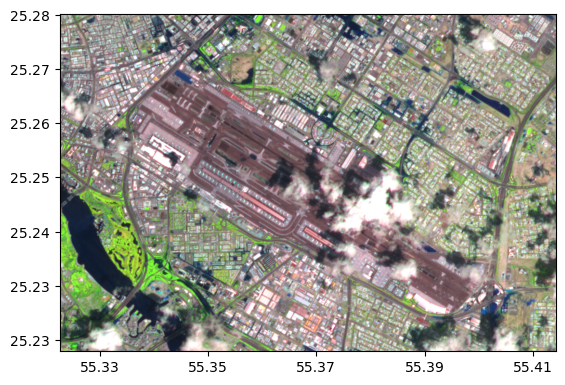

In [8]:
swirnirred = (img_local.isel({"band": [bands.index(b) for b in ["B11", "B8", "B4"]]}) / 4_500.0).clip(0, 1)

plot.show(swirnirred)

## Load the model - UNetMobV2_V1

In [9]:
model = cloudsen12.load_model_by_name(name="UNetMobV2_V1", weights_folder="cloudsen12_models")

c:\Users\tymot\Documents\praca\pineapple\meteors\examples\lime\cloudsen12_models\cloudsen12.py:206: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(weight

In [10]:
cloudsen12.MODELS_CLOUDSEN12.keys()

dict_keys(['cloudsen12', 'UNetMobV2_V1', 'UNetMobV2_V2', 'cloudsen12l2a', 'dtacs4bands', 'landsat30'])

In [11]:
cloudmask = model.predict(img_local / 10_000)

Text(0.5, 0.98, 'Cloud mask generated by UNetMobV2_V1')

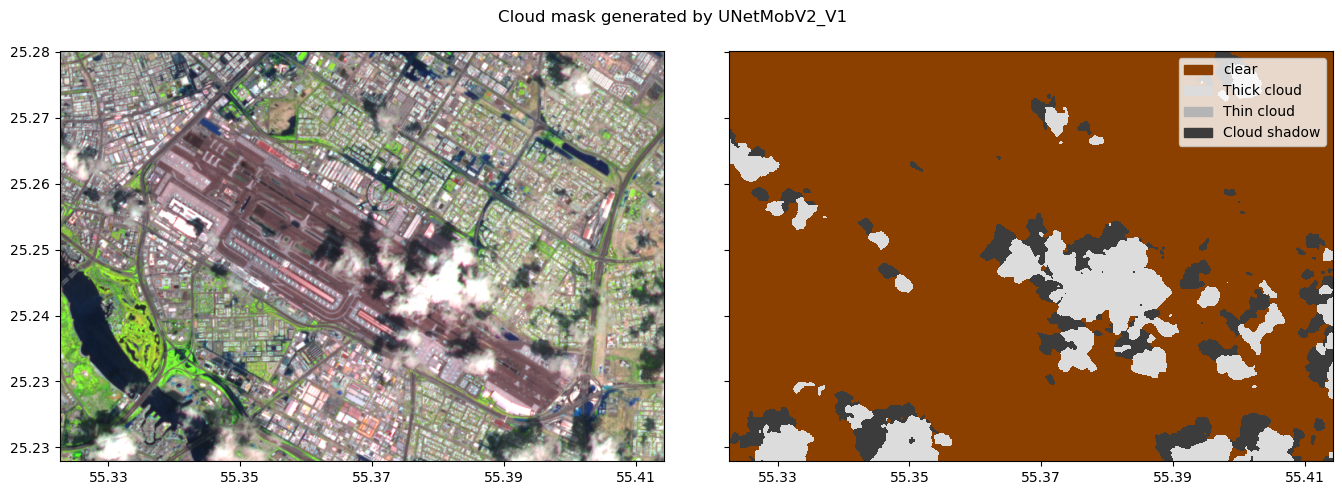

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=True, tight_layout=True)

plot.show(swirnirred, ax=ax[0])
cloudsen12.plot_cloudSEN12mask(cloudmask, ax=ax[1])
fig.suptitle("Cloud mask generated by UNetMobV2_V1")

## Explanations

In [13]:
import meteors as mt
import torch
import numpy as np

sentinel_central_wavelengths = [
    442.7,
    492.4,
    559.8,
    664.6,
    704.1,
    740.5,
    782.8,
    832.8,
    864.7,
    945.1,
    1373.5,
    1613.7,
    2202.4,
]

<Axes: >

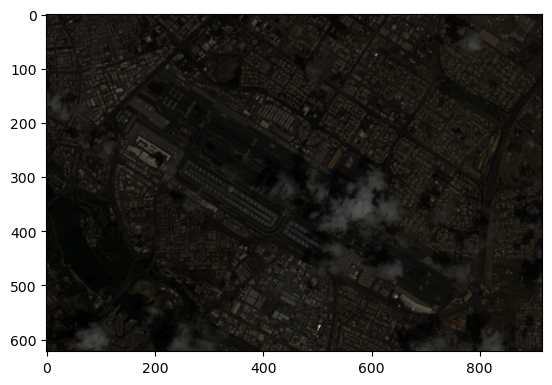

In [19]:
hsi_image = mt.HSI(
    image=img_local.values.astype(float) / img_local.values.max(), wavelengths=sentinel_central_wavelengths
)

mt.visualize.visualize_hsi(hsi_image)

In [20]:
explainable_model = mt.utils.models.ExplainableModel(model.predict, problem_type="segmentation")

C:\Users\tymot\AppData\Local\Temp\ipykernel_30564\2061039508.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  segmentation_mask_raw = torch.tensor(segmentation_mask_raw)


(-0.5, 915.5, 621.5, -0.5)

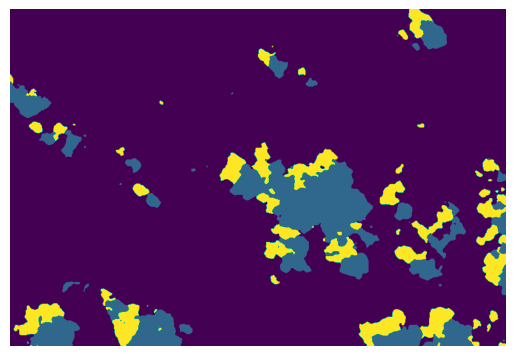

In [21]:
segmentation_mask_raw = explainable_model(hsi_image.image)
segmentation_mask_raw = torch.tensor(segmentation_mask_raw)

plt.imshow(segmentation_mask_raw[0])
plt.axis("off")

In order to create explanations we need to transform the problem into a simpler regression problem using a postprocessing function.

In [22]:
from meteors.utils.utils import agg_segmentation_postprocessing

postprocessing = agg_segmentation_postprocessing(classes_numb=4)

torch.int8

In [29]:
binary_mask = torch.ones_like(segmentation_mask_raw).to(torch.bool)

postprocessing(segmentation_mask_raw, binary_mask)

tensor([[478777.,  56101.,      0.,  34874.]])

In [30]:
# cast it into 4 channels, where each channel corresponds to a class
segmentation_mask = torch.tensor(segmentation_mask_raw[0])

segmentation_mask = (
    torch.nn.functional.one_hot(segmentation_mask.to(torch.int64), num_classes=4).permute(2, 0, 1).float()
)

C:\Users\tymot\AppData\Local\Temp\ipykernel_30564\817995685.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  segmentation_mask = torch.tensor(segmentation_mask_raw[0])


Text(0.5, 0, 'Class')

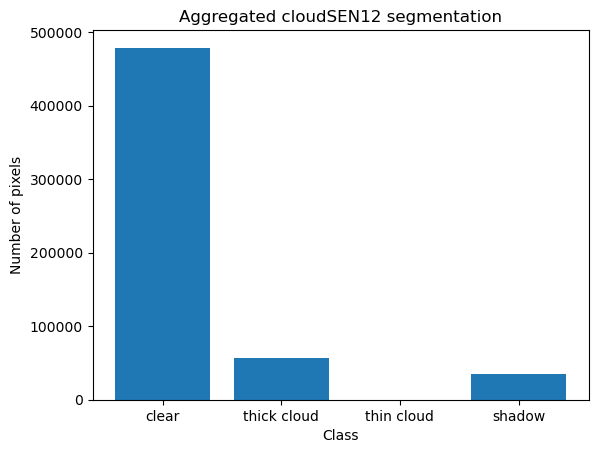

In [31]:
aggregated = segmentation_mask.sum(dim=(1, 2))
plt.bar(np.arange(4), aggregated)
plt.xticks(np.arange(4), ["clear", "thick cloud", "thin cloud", "shadow"])
plt.title("Aggregated cloudSEN12 segmentation")
plt.ylabel("Number of pixels")
plt.xlabel("Class")

In [33]:
lime = mt.attr.Lime(explainable_model=explainable_model)

seg_mask = lime.get_segmentation_mask(hsi_image, segmentation_method="slic", num_interpret_features=100)

attributes = lime.get_spatial_attributes(
    hsi_image, target=0, segmentation_mask=seg_mask, postprocessing_segmentation_output=postprocessing
)

2024-09-25 15:10:36.504 | WARNING  | meteors.attr.explainer:device:153 - Not a torch model, setting device to cpu


Score of the attribution: 1.0


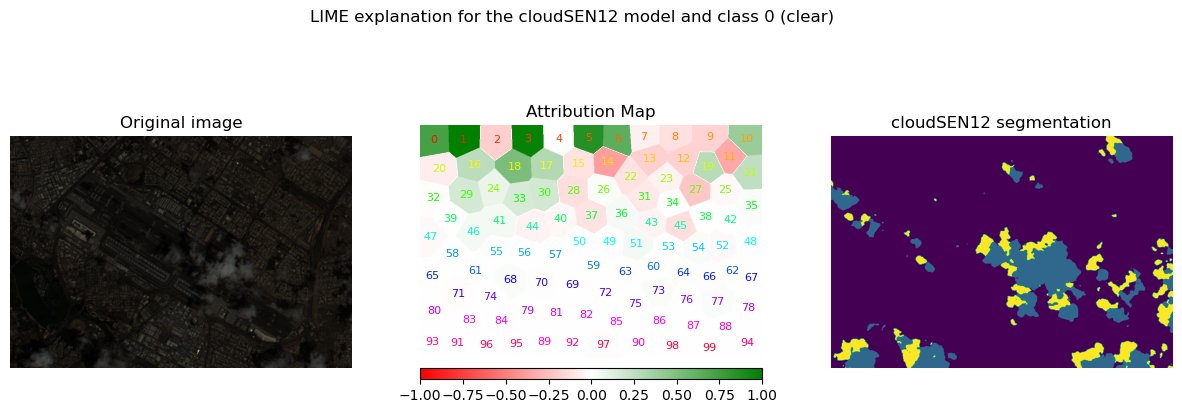

In [34]:
fig, ax = mt.visualize.visualize_spatial_attributes(attributes, use_pyplot=False)
fig.suptitle("LIME explanation for the cloudSEN12 model and class 0 (clear)")
ax[2].clear()
ax[2].imshow(segmentation_mask_raw[0])
ax[2].axis("off")
ax[2].set_title("cloudSEN12 segmentation")
print(f"Score of the attribution: {attributes.score}")

Score of the attribution: 1.0


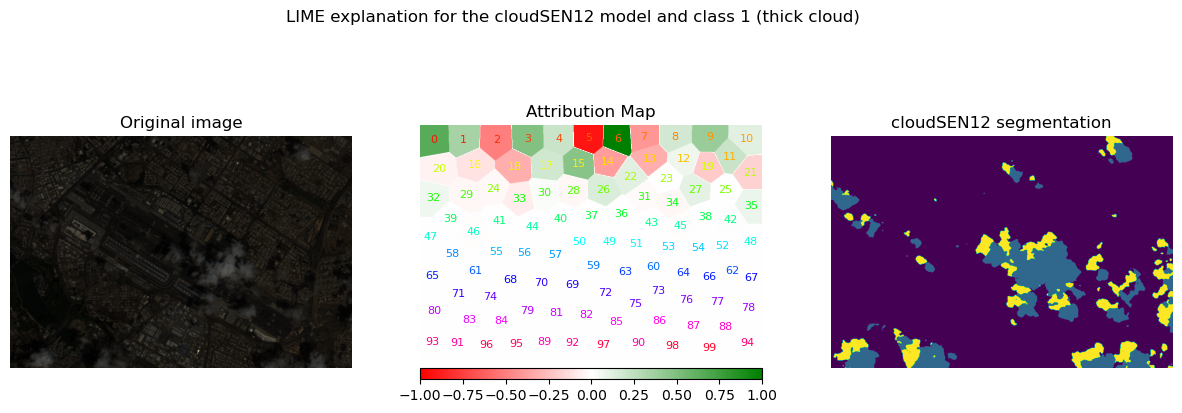

In [35]:
attributes = lime.get_spatial_attributes(
    hsi_image, target=1, segmentation_mask=seg_mask, postprocessing_segmentation_output=postprocessing, num_samples=100
)

fig, ax = mt.visualize.visualize_spatial_attributes(attributes, use_pyplot=False)
fig.suptitle("LIME explanation for the cloudSEN12 model and class 1 (thick cloud)")
ax[2].clear()
ax[2].imshow(segmentation_mask_raw[0])
ax[2].axis("off")
ax[2].set_title("cloudSEN12 segmentation")
print(f"Score of the attribution: {attributes.score}")

In [36]:
band_indices = {
    "B01": 0,
    "B02": 1,
    "B03": 2,
    "B04": 3,
    "B05": 4,
    "B06": 5,
    "B07": 6,
    "B08": 7,
    "B8A": 8,
    "B09": 9,
    "B10": 10,
    "B11": 11,
    "B12": 12,
}

band_mask, band_names = lime.get_band_mask(hsi_image, band_indices=band_indices)

attributes = lime.get_spectral_attributes(
    hsi_image, target=0, band_mask=band_mask, band_names=band_names, postprocessing_segmentation_output=postprocessing
)

c:\Users\tymot\miniconda3\envs\xai-tutorial\Lib\site-packages\meteors\attr\lime_base.py:738: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn("Minimum element in feature mask is not 0, shifting indices to" " start at 0.")


2024-09-25 15:11:10.867 | WARNING  | meteors.utils.utils:adjust_shape:112 - The source tensor could not be broadcasted to match the target tensor shape. Broadcasting target tensor to match the source tensor shape.
2024-09-25 15:11:13.167 | WARNING  | meteors.utils.utils:adjust_shape:112 - The source tensor could not be broadcasted to match the target tensor shape. Broadcasting target tensor to match the source tensor shape.
2024-09-25 15:11:14.433 | WARNING  | meteors.utils.utils:adjust_shape:112 - The source tensor could not be broadcasted to match the target tensor shape. Broadcasting target tensor to match the source tensor shape.


Score of the attribution: 1.0


Text(0.5, 0.98, 'LIME explanation for the cloudSEN12 model and class 0 (clear)')

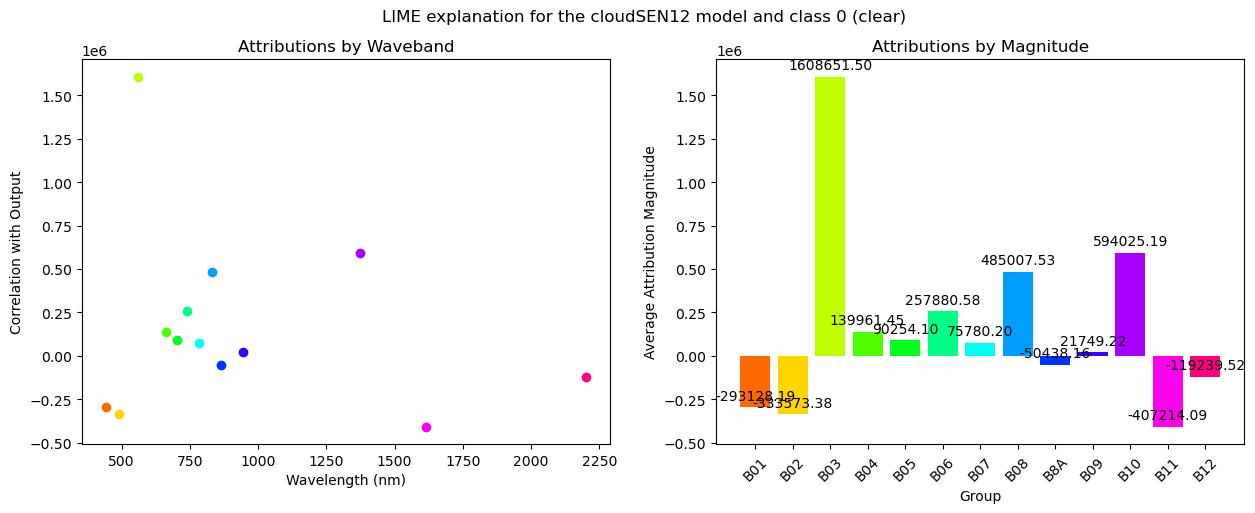

In [37]:
mt.visualize.visualize_spectral_attributes(attributes)
print(f"Score of the attribution: {attributes.score}")
fig = plt.gcf()
fig.suptitle("LIME explanation for the cloudSEN12 model and class 0 (clear)")

the bands B11, B08 and B04 are used usually to segment the clouds. This hints that possibly, this method of explanations is valid

c:\Users\tymot\miniconda3\envs\xai-tutorial\Lib\site-packages\meteors\attr\lime_base.py:738: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn("Minimum element in feature mask is not 0, shifting indices to" " start at 0.")


2024-09-25 15:11:43.864 | WARNING  | meteors.utils.utils:adjust_shape:112 - The source tensor could not be broadcasted to match the target tensor shape. Broadcasting target tensor to match the source tensor shape.
2024-09-25 15:11:56.429 | WARNING  | meteors.utils.utils:adjust_shape:112 - The source tensor could not be broadcasted to match the target tensor shape. Broadcasting target tensor to match the source tensor shape.
2024-09-25 15:12:09.242 | WARNING  | meteors.utils.utils:adjust_shape:112 - The source tensor could not be broadcasted to match the target tensor shape. Broadcasting target tensor to match the source tensor shape.
2024-09-25 15:12:21.343 | WARNING  | meteors.utils.utils:adjust_shape:112 - The source tensor could not be broadcasted to match the target tensor shape. Broadcasting target tensor to match the source tensor shape.
2024-09-25 15:12:33.592 | WARNING  | meteors.utils.utils:adjust_shape:112 - The source tensor could not be broadcasted to match the target tenso

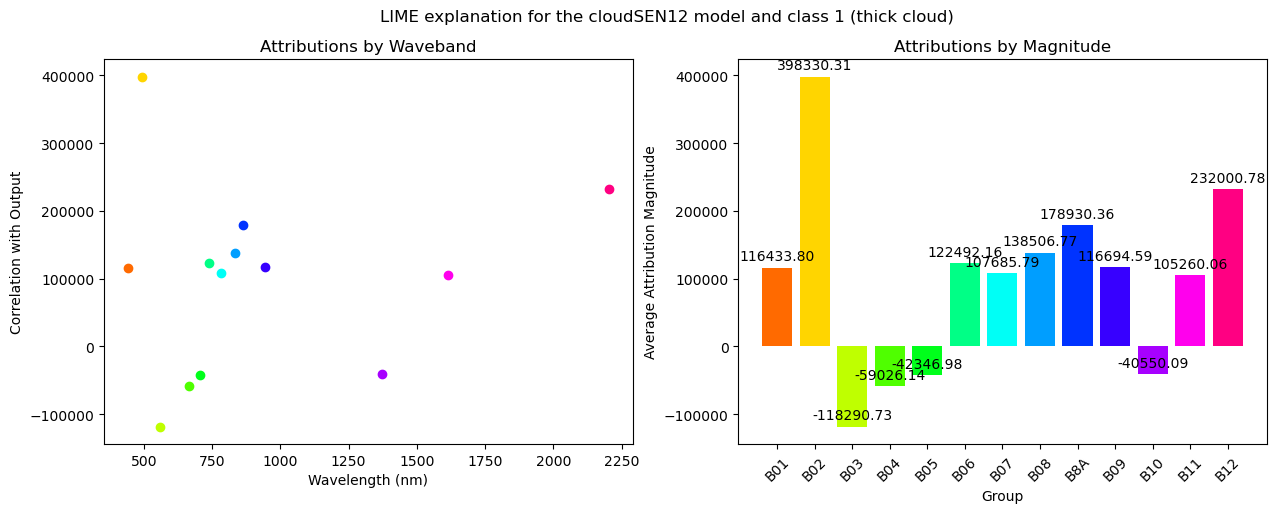

In [38]:
attributes = lime.get_spectral_attributes(
    hsi_image,
    target=1,
    band_mask=band_mask,
    band_names=band_names,
    postprocessing_segmentation_output=postprocessing,
    n_samples=100,
    perturbations_per_eval=20,
)

mt.visualize.visualize_spectral_attributes(attributes)
print(f"Score of the attribution: {attributes.score}")
fig = plt.gcf()
fig.suptitle("LIME explanation for the cloudSEN12 model and class 1 (thick cloud)")
plt.show()